<a href="https://colab.research.google.com/github/carlosperez1997/JOBarcelona22_DataScience/blob/main/JOBarcelona22_DataScience_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# JOBarcelona ’22 | Data Science
# **Modelo de predicción**
**Desarrollado por**: Carlos Pérez Ricardo

**Puesto**: Data Scientist en Grupo Hotusa

En este notebook se construirá un modelo de Machine Learning que determina qué tipo de insecto corresponde cada registro sabiendo sus atributos: hora, la lectura de los sensores y su combinación. 

El modelo que se obtiene tiene un F1-score macro de 0.99417 en TRAIN y 0.83230 en test. Hay claramente un overfitting!

Pero este overfitting es inevitable porque hay muy pocos registros (7000 únicamente). Pese a entrenar un modelo con unos hyperparameters no muy agresivos, el modelo tiende a memorizar rápidamente los valores en train (pese a realizar Cross Validation con altas particiones). 

Se sugiere conseguir más datos o bien generar datos sintéticos (aunque estos datos serían inventados). 

## **Data Understanding**
El dataset contiene datos de las mediciones de los sensores, el tiempo de las mediciones y el tipo de insecto identificado.

El dataset 'train.csv' contiene las siguientes variables:

* *Hour*: Hora a la que se ha hecho la medición.

* *Minutes*: Minutos en los que se ha realizado la medición.

* *Sensor_alpha*: Posición del insecto al sensor alpha.

* *Sensor_beta*: Posición del insecto al sensor beta.

* *Sensor_gamma*: Posición del insecto al sensor gamma.

* *Sensor_alpha_plus*: Posición del insecto al sensor alpha+.

* *Sensor_beta_plus*: Posición del insecto al sensor beta+.

* *Sensor_gamma_plus*: Posición del insecto al sensor gamma+.

* *Insect*: Categoría de insecto.
  - 0 -> Lepidoptero
  - 1 -> Himenoptera
  - 2 -> Diptera

# **Generación de los modelos**

En este apartado se van a construir diferentes modelos de predicción con el objetivo de obtener la configuración y el modelo que mejor predice el target. Varias tipologías de modelos van a ser testeadas:

- **SVM**: Se aplica un Support Vector Machines, para ello primero hay que normalizar los datos con un StandardScaler. 

- **PCA-KNN**: Se aplicará una PCA (Principal Componenent Analysis) para reducir el número de features para después aplicar un modelo de KNN (K-Nearest Neighbours).

- **LDA-KNN**: Se aplicará una LDA (Linear Discriminant Analysis) para reducir el número de features para después aplicar un modelo de KNN (K-Nearest Neighbours).

- **Multiclass RF**: Multiclass Random Forest Classifier que predice el tipo de insecto directamente. El mismo modelo es capaz de decir a qué categoría de insecto pertenece el registro (multiclass classification)

- **SMOTE - Multiclass RF**: Como el número de registros para cada insecto es diferente se propone hacer un oversample de las categorías minotarias con el objetivo de que el modelo sepa reconocerlas. Se implementa un oversample con Synthetic Minority Over-sampling Technique (SMOTE) y después se entrena un Random Forest Classifier.

- **One for each - LGBM**: Se construye un modelo para insecto. Cada modelo predice la probabilidad de cada registro de pertener a ese tipo de insecto. La solución del modelo que predice 1 con la probabilidad más alta se selecciona.    

Otras tipologías de modelos que se podrían haber planteado son:
- DBSCAN: Similar a KNN. 
- Neural Nets: Encontrar la arquitectura no debería ser demasiado complicado al ser datos numéricos. Sería interesante deshacerse de las combinaciones lineales de los sensores, pues estas computaciones ya las hace la Red Neuronal.
- Ensembling: En lugar de una sola solución de un solo modelo, porque no combinar los diferentes modelos construidos. Puede ser que un modelo sea muy bueno prediciendo un tipo de insecto y otro tipo de modelo sea bueno reconociendo otro. Podríamos tomar conocimiento y aprendizaje de cada enfoque.


**Importación de los paquetes y datos**

In [1]:
# Basics
import pandas as pd
import numpy as np
import os

# Tools
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import sklearn.preprocessing as pp
from imblearn.over_sampling import SMOTE, SMOTENC
from collections import Counter

# Models
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score 

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

In [2]:
DIR = '/content'
TARGET = 'Insect'
random_state = 42

In [3]:
train_df = pd.read_csv(os.path.join(DIR,'train.csv'), index_col = 0)

In [4]:
train_df.shape

(7001, 9)

In [5]:
train_df['Hour'] =  train_df['Hour'].astype('category')
train_df['Insect'] =  train_df['Insect'].astype('category')

In [6]:
vars = ['Sensor_alpha', 'Sensor_beta', 'Sensor_gamma', 'Sensor_alpha_plus', 'Sensor_beta_plus', 'Sensor_gamma_plus']

## Generación de nuevos atributos

Generamos los atributos que son combinación lineal de 2 y 3 atributos (datos de sensores). 

In [7]:
# 2 comb
n_sum, n_diff, n_mult = 6, 6, 6

# 3 comb
n_sumsum, n_sumdiff, n_summult = 4, 4, 4
n_diffdiff, n_diffsum, n_diffmult = 3, 3, 3
n_multmult, n_multsum, n_multdiff = 3, 3, 2

vars = ['Sensor_alpha', 'Sensor_beta', 'Sensor_gamma', 'Sensor_alpha_plus', 'Sensor_beta_plus', 'Sensor_gamma_plus']

In [8]:
def op_2comp(df, vars, fun):
    vars_ = vars.copy()
     
    for var1 in vars:
        vars_.remove(var1)
        for var2 in vars_:
            if fun == 'sum':
                df[var1+'_'+var2+'_x'] = df[var1] + df[var2]
            elif fun == 'diff':
                df[var1+'_'+var2+'_x'] = df[var1] - df[var2]
            elif fun == 'mult':
                df[var1+'_'+var2+'_x'] = df[var1] * df[var2]

    cols = [x for x in df.columns if '_x' in x]
    cols_map = { col : str(col).replace('x',fun) if '_x' in col else col for col in cols }
    df = df.rename(columns=cols_map)
    cols = [x for x in df.columns if fun in x]

    diff_among_cats = {}

    if TARGET in df.columns: 
        for col in cols:
            x = df.groupby(TARGET)[col].describe().reset_index()
            diff_among_cats[col] = x['25%'].max() - x['25%'].min() + x['75%'].max() - x['75%'].min()

    return(df, diff_among_cats)

In [9]:
def op_3comp(df, vars, fun1, fun2):
    vars_1 = vars.copy()
    vars_2 = vars.copy()

    for var1 in vars: 
        for var2 in vars_1:
            for var3 in vars_2:
                #print(var1,var2,var3)

                if fun1 == 'sum' and fun2 == 'sum':
                    df[var1+'_'+var2+'_'+var3+'_x'] = df[var1] + df[var2] + df[var3]
                elif fun1 == 'sum' and fun2 == 'diff':
                    df[var1+'_'+var2+'_'+var3+'_x'] = df[var1] + df[var2] - df[var3]
                elif fun1 == 'diff' and fun2 == 'sum':
                    df[var1+'_'+var2+'_'+var3+'_x'] = df[var1] - df[var2] + df[var3]
                elif fun1 == 'diff' and fun2 == 'diff':
                    df[var1+'_'+var2+'_'+var3+'_x'] = df[var1] - df[var2] - df[var3]
                elif fun1 == 'sum' and fun2 == 'mult':
                    df[var1+'_'+var2+'_'+var3+'_x'] = df[var1] + df[var2] * df[var3]
                elif fun1 == 'mult' and fun2 == 'sum':
                    df[var1+'_'+var2+'_'+var3+'_x'] = df[var1] * df[var2] - df[var3]
                elif fun1 == 'diff' and fun2 == 'mult':
                    df[var1+'_'+var2+'_'+var3+'_x'] = df[var1] - df[var2] * df[var3]
                elif fun1 == 'mult' and fun2 == 'diff':
                    df[var1+'_'+var2+'_'+var3+'_x'] = df[var1] * df[var2] - df[var3]
                elif fun1 == 'mult' and fun2 == 'mult':
                    df[var1+'_'+var2+'_'+var3+'_x'] = df[var1] * df[var2] * df[var3]
            try:
                vars_2.remove(var2)
            except:
                pass
        vars_1.remove(var1)
        try:
            vars_2.remove(var1)
        except:
            pass

    cols = [x for x in df.columns if '_x' in x]
    cols_map = { col : str(col).replace('x',fun1+fun2) if '_x' in col else col for col in cols }
    df = df.rename(columns=cols_map)
    cols = [x for x in df.columns if fun1+fun2 in x]

    diff_among_cats = {}
    
    if TARGET in df.columns:
        for col in cols:
            x = df.groupby(TARGET)[col].describe().reset_index()
            diff_among_cats[col] = x['25%'].max() - x['25%'].min() + x['75%'].max() - x['75%'].min()
            #distcountplot(train_df, col, 'Insect')

    return(df, diff_among_cats)

In [10]:
def plot_and_keep(df, diff_among_cats, keep, n=3):
    cats_order = pd.DataFrame.from_dict({'col':diff_among_cats.keys(), 'value':diff_among_cats.values()})
    cats_order = cats_order.sort_values('value', ascending=False)

    #for col in cats_order['col'].head(5):
    #    distcountplot(df, col, TARGET)
        
    for col in cats_order['col'].head(n):
        keep.append(col)

    return(keep)

In [11]:
keep = list(train_df.columns)

### Combinación de 2 elementos

Para saber más véase EDA.

In [12]:
train_df, diff_among_cats = op_2comp(train_df, vars, 'sum')
keep = plot_and_keep(train_df, diff_among_cats, keep, n_sum)

In [13]:
train_df, diff_among_cats = op_2comp(train_df, vars, 'diff')
keep = plot_and_keep(train_df, diff_among_cats, keep, n_diff)

In [14]:
train_df, diff_among_cats = op_2comp(train_df, vars, 'mult')
keep = plot_and_keep(train_df, diff_among_cats, keep, n_mult)

### Combinación de 3 elementos

Para saber más véase EDA.

In [15]:
train_df, diff_among_cats = op_3comp(train_df, vars, 'sum', 'sum')
keep = plot_and_keep(train_df, diff_among_cats, keep, n_sumsum)

In [16]:
train_df, diff_among_cats = op_3comp(train_df, vars, 'sum', 'diff')
keep = plot_and_keep(train_df, diff_among_cats, keep, n_sumdiff)

In [17]:
train_df, diff_among_cats = op_3comp(train_df, vars, 'sum', 'mult')
keep = plot_and_keep(train_df, diff_among_cats, keep, n_summult)

In [18]:
train_df, diff_among_cats = op_3comp(train_df, vars, 'diff', 'diff')
keep = plot_and_keep(train_df, diff_among_cats, keep, n_diffdiff)

In [19]:
train_df, diff_among_cats = op_3comp(train_df, vars, 'diff', 'sum')
keep = plot_and_keep(train_df, diff_among_cats, keep, n_diffsum)

In [20]:
train_df, diff_among_cats = op_3comp(train_df, vars, 'diff', 'mult')
keep = plot_and_keep(train_df, diff_among_cats, keep, n_diffmult)

In [21]:
train_df, diff_among_cats = op_3comp(train_df, vars, 'mult', 'mult')
keep = plot_and_keep(train_df, diff_among_cats, keep, n_multmult)

In [22]:
train_df, diff_among_cats = op_3comp(train_df, vars, 'mult', 'sum')
keep = plot_and_keep(train_df, diff_among_cats, keep, n_multsum)

In [23]:
train_df, diff_among_cats = op_3comp(train_df, vars, 'mult', 'diff')
keep = plot_and_keep(train_df, diff_among_cats, keep, n_multdiff)

En lugar de quedarnos con todos los nuevos atributos, nos quedamos únicamente con aquellos atributos que muestran una distribución en el que alguno de los insectos tiene valores distintos al resto. 

In [24]:
train_df = train_df[keep]
train_df.shape

(7001, 56)

# Limpieza de los datos

En este apartado se realizará una limpieza del dataset. Con suerte, no hay datos nulos. Por lo que únicamente se eliminarán las columnas que tengan una alta correlación.

Si 2 variables tienen una correlación alta (de valores cercanos o iguales a 1 o -1), aportan la misma información al modelo. Por lo que es necesario deshacerse de alguna de ellas. 

En nuestro caso, se eliminarán alguna de las dos columnas donde exista una correlación lineal absoluta mayor a 0.92.

In [25]:
high_corr_df = pd.DataFrame()
visit_cols = list(train_df.select_dtypes(include=np.number).columns)

for x in train_df.select_dtypes(include=np.number).columns:
    for y in visit_cols:
        if x != y:
            if np.array(train_df[[x,y]].corr())[0,1] > 0.8:
                high_corr_df = high_corr_df.append({'var1':x, 'var2':y, 'corr':np.array(train_df[[x,y]].corr())[0,1]}, ignore_index=True)
    visit_cols.remove(x)

high_corr_df.sort_values('corr', ascending=False)

,var1,var2,corr
41,Sensor_alpha_Sensor_alpha_Sensor_gamma_multsum,Sensor_alpha_Sensor_alpha_Sensor_gamma_multdiff,1.000000
37,Sensor_alpha_Sensor_alpha_Sensor_alpha_plus_mu...,Sensor_alpha_Sensor_alpha_Sensor_alpha_plus_mu...,1.000000
27,Sensor_beta_Sensor_gamma_mult,Sensor_alpha_Sensor_beta_Sensor_gamma_summult,0.999988
25,Sensor_beta_Sensor_alpha_plus_mult,Sensor_alpha_Sensor_beta_Sensor_alpha_plus_sum...,0.999988
26,Sensor_gamma_Sensor_alpha_plus_mult,Sensor_alpha_Sensor_gamma_Sensor_alpha_plus_su...,0.999987
43,Sensor_alpha_Sensor_alpha_Sensor_gamma_plus_mu...,Sensor_alpha_Sensor_alpha_Sensor_gamma_multdiff,0.999940
39,Sensor_alpha_Sensor_alpha_Sensor_gamma_multsum,Sensor_alpha_Sensor_alpha_Sensor_gamma_plus_mu...,0.999940
42,Sensor_alpha_Sensor_alpha_Sensor_gamma_plus_mu...,Sensor_alpha_Sensor_alpha_Sensor_alpha_plus_mu...,0.999937
36,Sensor_alpha_Sensor_alpha_Sensor_alpha_plus_mu...,Sensor_alpha_Sensor_alpha_Sensor_gamma_plus_mu...,0.999937
44,Sensor_alpha_Sensor_alpha_Sensor_alpha_plus_mu...,Sensor_alpha_Sensor_alpha_Sensor_gamma_multdiff,0.999927


In [26]:
# Drop features with high correlation 
for col in high_corr_df[(high_corr_df['corr'] >= 0.92) | (high_corr_df['corr'] <= -0.92)]['var2']:
    try:
        del train_df[col]
    except:
        pass

In [27]:
high_corr_df = pd.DataFrame()
visit_cols = list(train_df.select_dtypes(include=np.number).columns)

for x in train_df.select_dtypes(include=np.number).columns:
    for y in visit_cols:
        if x != y:
            if np.array(train_df[[x,y]].corr())[0,1] > 0.8:
                high_corr_df = high_corr_df.append({'var1':x, 'var2':y, 'corr':np.array(train_df[[x,y]].corr())[0,1]}, ignore_index=True)
    visit_cols.remove(x)

high_corr_df.sort_values('corr', ascending=False)

,var1,var2,corr
5,Sensor_gamma,Sensor_alpha_Sensor_gamma_Sensor_gamma_sumsum,0.919583
11,Sensor_beta_Sensor_alpha_plus_diff,Sensor_alpha_Sensor_beta_Sensor_alpha_plus_sum...,0.914604
6,Sensor_alpha_Sensor_beta_sum,Sensor_alpha_Sensor_beta_Sensor_alpha_plus_sum...,0.891621
14,Sensor_alpha_Sensor_beta_diff,Sensor_alpha_Sensor_beta_Sensor_alpha_plus_dif...,0.885972
2,Sensor_beta,Sensor_beta_Sensor_alpha_plus_diff,0.881264
17,Sensor_alpha_Sensor_beta_Sensor_alpha_plus_sum...,Sensor_alpha_Sensor_alpha_plus_Sensor_alpha_pl...,0.880640
13,Sensor_gamma_Sensor_alpha_plus_diff,Sensor_alpha_Sensor_gamma_Sensor_alpha_plus_su...,0.864502
16,Sensor_beta_Sensor_gamma_plus_diff,Sensor_alpha_Sensor_beta_Sensor_gamma_plus_sum...,0.863596
12,Sensor_beta_Sensor_gamma_diff,Sensor_alpha_Sensor_beta_Sensor_gamma_sumdiff,0.861400
9,Sensor_alpha_Sensor_alpha_plus_sum,Sensor_alpha_Sensor_beta_Sensor_alpha_plus_dif...,0.861017


## Train Test split

Dividimos el dataset en 2 partes: train y test.
El dataset en train se utilizará para entrenar el modelo. Y el dataset de test se utilizará para observar que tan buen performance tiene el modelo ante datos que no ha visto. 

In [28]:
train_df.shape

(7001, 45)

In [29]:
features = list(train_df.columns)
features.remove(TARGET)
n_features = len(features)

In [30]:
X = train_df[features]
y = train_df[TARGET]

In [31]:
# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=random_state)

n_classes = len(np.unique(y))

In [32]:
print(X_train.shape)
print(X_test.shape)

(5600, 44)
(1401, 44)


# Selección del modelo

## Support Vector Machines (SVM)


In [33]:
X_train_norm = X_train.copy(deep=True)
X_test_norm = X_test.copy(deep=True)

for col in X_train.columns:
    sc = StandardScaler()
    X_train_norm[col] = sc.fit_transform(X_train_norm[[col]])
    X_test_norm[col] = sc.transform(X_test_norm[[col]])

In [34]:
svm = SVC()
svm.fit(X_train_norm, y_train)

y_pred_train = svm.predict(X_train_norm)
y_pred_test = svm.predict(X_test_norm)
    
# Compute the nearest neighbor accuracy on the embedded test set
print('PCA')
print("TRAIN:", f1_score(y_train, y_pred_train, average='macro'))
print("TEST:", f1_score(y_test, y_pred_test, average='macro'))

PCA
TRAIN: 0.788489616240866
TEST: 0.756365856741191


## PCA-KNN

Se ha entrenado considerando los valores de los 3 vecinos más próximos.

In [35]:
n_neighbors = 3

# Reduce dimension to 2 with PCA
pca = make_pipeline(StandardScaler(), PCA(n_components=20, random_state=random_state))

# Reduce dimension to 2 with LinearDiscriminantAnalysis
lda = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis(n_components=2))

# Reduce dimension to 2 with NeighborhoodComponentAnalysis
nca = make_pipeline(
    StandardScaler(),
    NeighborhoodComponentsAnalysis(n_components=3, random_state=random_state),
)

In [36]:
# Use a nearest neighbor classifier to evaluate the methods
pca_knn = KNeighborsClassifier(n_neighbors=n_neighbors)

pca.fit(X_train, y_train)

# Fit a nearest neighbor classifier on the embedded training set
pca_knn.fit(pca.transform(X_train), y_train)
    
y_pred_train = pca_knn.predict(pca.transform(X_train))
y_pred_test = pca_knn.predict(pca.transform(X_test))
    
# Compute the nearest neighbor accuracy on the embedded test set
print('PCA')
print("TRAIN:", f1_score(y_train, y_pred_train, average='macro'))
print("TEST:", f1_score(y_test, y_pred_test, average='macro'))

PCA
TRAIN: 0.8336438591986542
TEST: 0.7141484855835957


## LDA-KNN

In [37]:
# Use a nearest neighbor classifier to evaluate the methods
lda_knn = KNeighborsClassifier(n_neighbors=n_neighbors)

lda.fit(X_train, y_train)

# Fit a nearest neighbor classifier on the embedded training set
lda_knn.fit(lda.transform(X_train), y_train)
    
y_pred_train = lda_knn.predict(lda.transform(X_train))
y_pred_test = lda_knn.predict(lda.transform(X_test))
    
# Compute the nearest neighbor accuracy on the embedded test set
print('LDA')
print("TRAIN:", f1_score(y_train, y_pred_train, average='macro'))
print("TEST:", f1_score(y_test, y_pred_test, average='macro'))

LDA
TRAIN: 0.8005699558242952
TEST: 0.6488689492368095


## Multiclass RF

In [38]:
rf = RandomForestClassifier(n_estimators = 100, max_depth=10, min_samples_leaf=10, random_state=random_state)
rf.fit(X_train, y_train)

y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

print("TRAIN:", f1_score(y_train, y_pred_train, average='macro'))
print("TEST:", f1_score(y_test, y_pred_test, average='macro'))

TRAIN: 0.870733521847339
TEST: 0.793145258299865


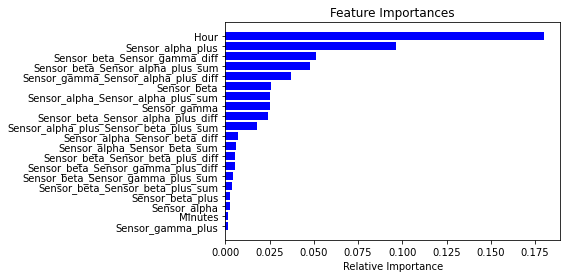

In [39]:
importances = rf.feature_importances_[:20]
indices = np.argsort(importances)
features = X_train.columns

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [40]:
rf = RandomForestClassifier(random_state=random_state)

param_dist = {"max_depth": [5, 10, 12, 15],
                  "n_estimators": [20, 30, 40, 50]
                 }
grid_search = GridSearchCV(rf, n_jobs=-1, param_grid=param_dist, cv = 9, scoring='f1_macro', verbose=10)
grid_search.fit(X_train, y_train)
model = grid_search.best_estimator_
    
print(model)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print("TRAIN:", f1_score(y_train, y_pred_train, average='macro'))
print("TEST:", f1_score(y_test, y_pred_test, average='macro'))

Fitting 9 folds for each of 16 candidates, totalling 144 fits
RandomForestClassifier(max_depth=15, n_estimators=50, random_state=42)
TRAIN: 0.9941749551334699
TEST: 0.8323041983882796


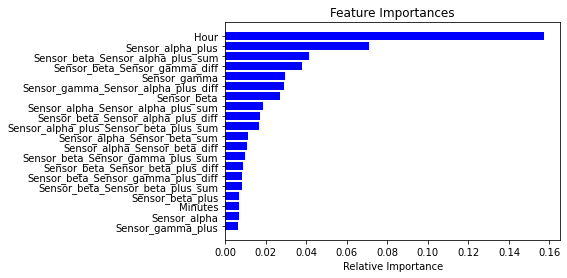

In [41]:
importances = model.feature_importances_[:20]
indices = np.argsort(importances)
features = X_train.columns

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

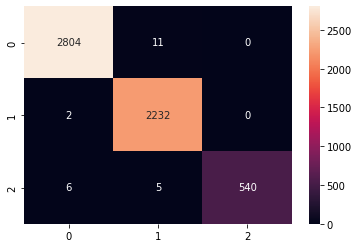

In [42]:
cf_matrix = confusion_matrix(y_train, y_pred_train)
sns.heatmap(cf_matrix, annot=True, fmt='.0f')

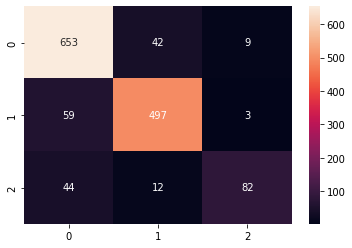

In [43]:
cf_matrix = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cf_matrix, annot=True, fmt='.0f')

## SMOTE - Multiclass RF

In [44]:
oversample = SMOTENC(categorical_features=[0])
X_train_ov, y_train_ov = oversample.fit_resample(X_train, y_train)

print('Before Sampling')
counter = Counter(y_train)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

print('\n After Sampling')
counter = Counter(y_train_ov)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Before Sampling
Class=0, n=2815 (40.209%)
Class=2, n=551 (7.870%)
Class=1, n=2234 (31.910%)

 After Sampling
Class=0, n=2815 (40.209%)
Class=2, n=2815 (40.209%)
Class=1, n=2815 (40.209%)


In [45]:
for col in X_train_ov.columns:
    X_train_ov[col] = X_train_ov[col].astype(int)
    X_train[col] = X_train[col].astype(int)
    X_test[col] = X_test[col].astype(int)

In [46]:
rf = RandomForestClassifier(random_state=random_state)

param_dist = {"max_depth": [20, 30, 35, 45, 50],
                  "n_estimators": [150, 200, 250, 300]
                 }
grid_search = GridSearchCV(rf, n_jobs=-1, param_grid=param_dist, cv = 5, scoring='f1_macro', verbose=20)
grid_search.fit(X_train_ov, y_train_ov)
smote_model = grid_search.best_estimator_
    
print(smote_model)
y_pred_train_ = smote_model.predict(X_train_ov)
y_pred_train = smote_model.predict(X_train)
y_pred_test = smote_model.predict(X_test)

print("TRAIN (oversample):", f1_score(y_train_ov, y_pred_train_, average='macro'))
print("TRAIN:", f1_score(y_train, y_pred_train, average='macro'))
print("TEST:", f1_score(y_test, y_pred_test, average='macro'))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
RandomForestClassifier(max_depth=35, n_estimators=250, random_state=42)
TRAIN (oversample): 1.0
TRAIN: 1.0
TEST: 0.8264109722131447


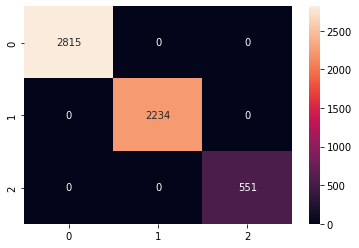

In [47]:
cf_matrix = confusion_matrix(y_train, y_pred_train)
sns.heatmap(cf_matrix, annot=True, fmt='.0f')

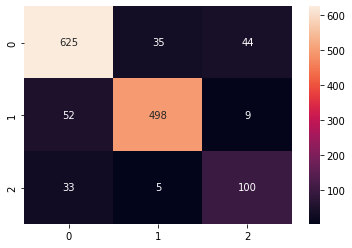

In [48]:
cf_matrix = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cf_matrix, annot=True, fmt='.0f')

## One to each - LGBM

In [49]:
# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=random_state)

all_pred_train = pd.DataFrame()
all_pred_test = pd.DataFrame()

for segment in range(0,n_classes):
    print(segment)
    
    y_train_onehot = y_train.apply(lambda x:1 if x == segment else 0)
    y_test_onehot = y_test.apply(lambda x:1 if x == segment else 0)

    true = y_train_onehot.loc[ y_train_onehot == 1].index.to_list()
    non_true = y_train_onehot.loc[ y_train_onehot == 0].sample( round(len(true)*0.8) ).index.to_list()
    idx = true + non_true
    
    X_train_ = X_train.loc[idx]
    y_train_onehot_ = y_train_onehot.loc[idx]

    #oversample = SMOTE()
    #X_train_, y_train_onehot_ = oversample.fit_resample(X_train, y_train_onehot)
    
    lgtrain_ = lgb.Dataset(X_train_, label=y_train_onehot_)
    
    lg = lgb.LGBMClassifier(silent=False)
    param_dist = {"max_depth": [20,30,50],
                  "learning_rate" : [0.05, 0.1],
                  "num_leaves": [20,30,50],
                  "n_estimators": [250]
                 }
    grid_search = GridSearchCV(lg, n_jobs=-1, param_grid=param_dist, cv = 3, scoring="roc_auc", verbose=10)
    grid_search.fit(X_train_, y_train_onehot_)
    model_ = grid_search.best_estimator_
    
    print(model)
    y_pred_train_ = model_.predict(X_train_)
    y_pred_train = model_.predict(X_train)
    y_pred_test = model_.predict(X_test)
    
    print("TRAIN (Oversample):", f1_score(y_train_onehot_, y_pred_train_))
    print("TRAIN:", f1_score(y_train_onehot, y_pred_train))
    print("TEST:", f1_score(y_test_onehot, y_pred_test))
    
    y_proba_train = model_.predict_proba(X_train)
    y_proba_test = model_.predict_proba(X_test)
    
    all_pred_train = pd.concat([all_pred_train, pd.DataFrame({'pred_'+str(segment):y_pred_train,'proba_'+str(segment):y_proba_train[:, 0]})], axis=1)
    all_pred_test = pd.concat([all_pred_test, pd.DataFrame({'pred_'+str(segment):y_pred_test,'proba_'+str(segment):y_proba_test[:, 0]})], axis=1)  
    
#all_pred_train['result'] = y_train.values
#all_pred_test['result'] = y_test.values

0
Fitting 3 folds for each of 18 candidates, totalling 54 fits
RandomForestClassifier(max_depth=15, n_estimators=50, random_state=42)
TRAIN (Oversample): 1.0
TRAIN: 0.9917442473212716
TEST: 0.9172510518934082
1
Fitting 3 folds for each of 18 candidates, totalling 54 fits
RandomForestClassifier(max_depth=15, n_estimators=50, random_state=42)
TRAIN (Oversample): 1.0
TRAIN: 0.97405711794201
TEST: 0.9428076256499134
2
Fitting 3 folds for each of 18 candidates, totalling 54 fits
RandomForestClassifier(max_depth=15, n_estimators=50, random_state=42)
TRAIN (Oversample): 1.0
TRAIN: 0.5682888540031398
TEST: 0.472168905950096


In [50]:
def obtain_results_(df):
    proba_cols = [col for col in df.columns if str.__contains__(col,"proba")]

    for col in range(0,n_classes):
        proba = 'proba_'+str(col)
        pred = 'pred_'+str(col)
        df.loc[df[pred] == 0,proba] = -abs(df.loc[all_pred_train[pred]== 0,proba])

    maxValueIndex = df[proba_cols].idxmax(axis = 1)

    df['FINAL'] = maxValueIndex

    df['FINAL'] = df['FINAL'].apply( lambda x: x.split('_')[1]).astype(int)
    
    return(df)

In [51]:
all_pred_train = obtain_results_(all_pred_train)
all_pred_test = obtain_results_(all_pred_test)

all_pred_train['ACTUAL'] = y_train.values
all_pred_test['ACTUAL'] = y_test.values
all_pred_train

,pred_0,proba_0,pred_1,proba_1,pred_2,proba_2,FINAL,ACTUAL
0,0,-9.995981e-01,1,1.401142e-05,0,-0.999639,1,1
1,1,1.482050e-03,0,-8.924414e-01,0,-0.999891,0,0
2,1,2.029336e-03,0,-9.999545e-01,0,-0.999194,0,0
3,0,-9.999011e-01,1,4.707965e-06,0,-0.845066,1,1
4,1,2.843329e-06,0,-9.999993e-01,0,-0.933923,0,0
...,...,...,...,...,...,...,...,...
5595,0,-9.999570e-01,1,7.411881e-07,0,-0.997514,1,1
5596,0,-9.976584e-01,1,6.724620e-05,0,-0.999953,1,1
5597,1,7.493316e-07,0,-9.999999e-01,0,-0.999979,0,0
5598,1,1.308185e-05,0,-9.999973e-01,0,-0.504222,0,0


In [52]:
print("TRAIN:", f1_score(all_pred_train['FINAL'], all_pred_train['ACTUAL'], average='macro'))
print("TEST:", f1_score(all_pred_test['FINAL'], all_pred_test['ACTUAL'], average='macro'))

TRAIN: 0.7845100018585653
TEST: 0.7181210483895316


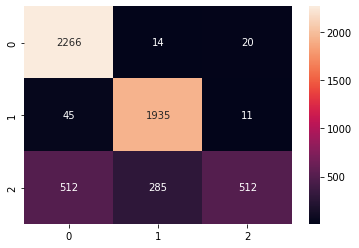

In [53]:
cf_matrix = confusion_matrix(all_pred_train['FINAL'], all_pred_train['ACTUAL'])
sns.heatmap(cf_matrix, annot=True, fmt='.0f')

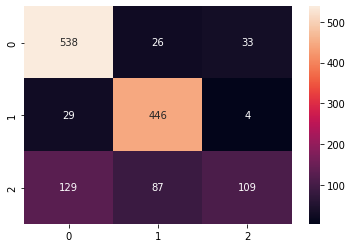

In [54]:
cf_matrix = confusion_matrix(all_pred_test['FINAL'], all_pred_test['ACTUAL'])
sns.heatmap(cf_matrix, annot=True, fmt='.0f')

# Modelo con la mejor performance

La tipología de modelos que mejor resultado ha dado ha sido: Multiclass RF. 
Este tipo de modelo se entrenará con todo el dataset y se utilizará el modelo para hacer las predicciones.

Se ha preferido utilizar todo el dataset para entrenar el modelo porque hay muchos pocos registros y de esta manera asegurar que el modelo construido ha visto la mayor cantidad de datos.

Para la construcción del modelo se realiza un Cross Validation con hasta 7 particiones y se hace Grid Search para encontrar los mejores hyperparameters.

In [61]:
rf = RandomForestClassifier(random_state=random_state)

param_dist = {"max_depth": [5, 10, 12, 15],
                  "n_estimators": [20, 30, 40, 50]
                 }
grid_search = GridSearchCV(rf, n_jobs=-1, param_grid=param_dist, cv = 9, scoring='f1_macro', verbose=10)
grid_search.fit(X[features], y)
model = grid_search.best_estimator_
    
print(model)
pred = model.predict(X)

print("TRAIN:", f1_score(y, pred, average='macro'))

Fitting 9 folds for each of 16 candidates, totalling 144 fits
RandomForestClassifier(max_depth=15, n_estimators=50, random_state=42)
TRAIN: 0.9896997406188582


# Predicciones finales

Una vez entrenado el modelo, se preparan los datos de test y se realizan las predicciones finales. Se guardan en un csv ('results.csv') para será evaluado por los jueces.

In [62]:
test_df = pd.read_csv(os.path.join(DIR,'test_x.csv'), index_col = 0)

In [63]:
test_df, diff_among_cats = op_2comp(test_df, vars, 'sum')
test_df, diff_among_cats = op_2comp(test_df, vars, 'diff')
test_df, diff_among_cats = op_2comp(test_df, vars, 'mult')

In [64]:
test_df, diff_among_cats = op_3comp(test_df, vars, 'sum', 'sum')
test_df, diff_among_cats = op_3comp(test_df, vars, 'sum', 'diff')
test_df, diff_among_cats = op_3comp(test_df, vars, 'sum', 'mult')
test_df, diff_among_cats = op_3comp(test_df, vars, 'diff', 'diff')
test_df, diff_among_cats = op_3comp(test_df, vars, 'diff', 'sum')
test_df, diff_among_cats = op_3comp(test_df, vars, 'diff', 'mult')
test_df, diff_among_cats = op_3comp(test_df, vars, 'mult', 'diff')
test_df, diff_among_cats = op_3comp(test_df, vars, 'mult', 'sum')
test_df, diff_among_cats = op_3comp(test_df, vars, 'mult', 'mult')

In [65]:
X_valida = test_df[features]
y_valida_pred = model.predict(X_valida)
y_valida_pred = pd.DataFrame(y_valida_pred, index=test_df.index, columns=['Insect'])

In [66]:
y_valida_pred.to_csv(os.path.join(DIR, 'results.csv'))